In [1]:
import numpy as np
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from core.cluster_validation import morphotopes_to_etcs

In [2]:
regions_datadir = "/data/uscuni-ulce/"
model_params = '_75_0_None_None_False'

In [3]:
v = 'v3'
regional_clusters = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/regional_clusters_{v}.pq')[0]
final_clusters = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/final_clusters_{v}.pq')
cdata = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cdata_{v}.pq')
regional_ward_morphotopes_data = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_input_data_{v}.pq')
linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/clusters/kmeans_linkage_{v}.npy')

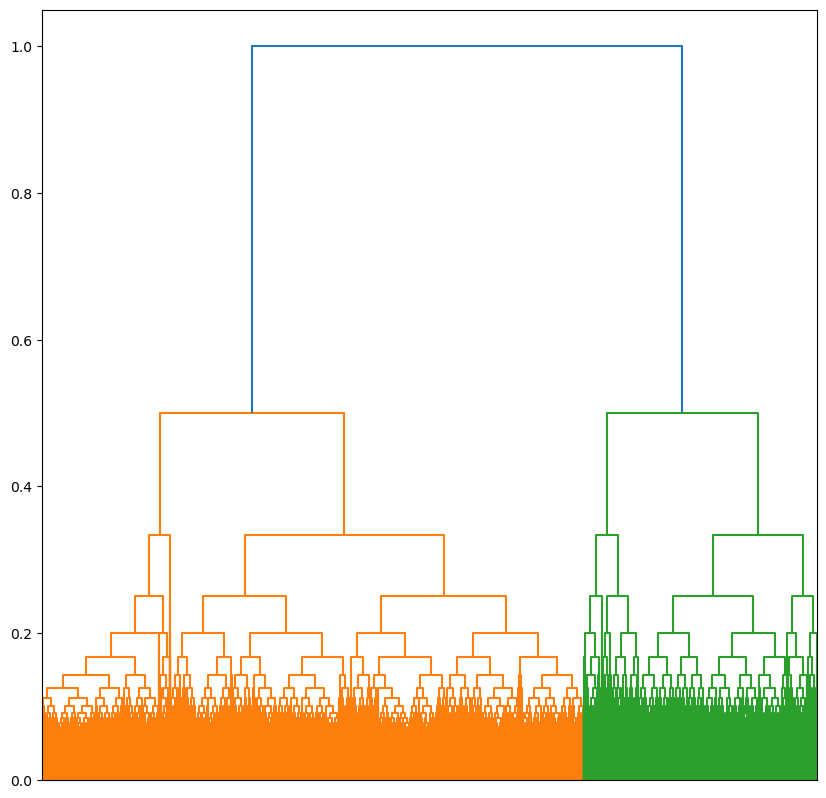

In [4]:
## final dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax, no_labels=True)

In [5]:
final_cutoff = 1/7 -0.00001
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
final_clusters.value_counts()

1     4611
50    3198
33    3161
47    3081
41    2724
      ... 
27       1
13       1
15       1
11       1
19       1
Name: count, Length: 108, dtype: int64

### Plotting

In [6]:
from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [255,255,255]

In [7]:
region_id = 69333 

# region_id = 99886 # bratislava

# region_id = 151676 # vilnius

# region_id = 8707 # mainz/frankfurt
# region_id = 5883 #  freiburg
# region_id = 38679 #munich
# region_id = 55763 # berlin

# region_id = 86873 # vienna

# region_id = 107131 # krakow


# region_id= 66593

In [8]:
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)

In [9]:
regional_clusters

4_0_0               4_164
4_0_1               4_712
4_0_10              4_734
4_0_100             4_903
4_0_101            4_1837
                  ...    
152511_809_0    152511_10
152511_8_0      152511_20
152511_8_1      152511_39
152511_8_2      152511_20
152511_901_0    152511_31
Name: 0, Length: 523595, dtype: object

In [10]:



## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")

In [11]:
etcs['geometry'] = etcs.simplify(1).to_crs(epsg=4326).make_valid()
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [12]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

CPU times: user 1.03 s, sys: 114 ms, total: 1.15 s
Wall time: 1.14 s


In [13]:
from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters - {final_cutoff}')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

In [14]:
from core.cluster_validation import get_color
layer.get_fill_color = final_colors.loc[etcs.final].values.astype('uint8')

### Interactive dendro

In [38]:
from core import interactive_dendrogram
import jscatter
import seaborn as sns


def get_subcluster_children(focus):
    if focus < n:
        return [focus]
    child, parent = linkage_matrix[focus - n, 0].astype(int), linkage_matrix[focus - n, 1].astype(int)
    children_ids = interactive_dendrogram.get_children(linkage_matrix, child, parent)
    children_morphotopes = regional_ward_morphotopes_data.iloc[children_ids].index
    return children_morphotopes

In [16]:
scatter_df, lines = interactive_dendrogram.get_dendrogram_scatter_data(linkage_matrix)

In [17]:
scatter = jscatter.Scatter(data=scatter_df, x='x', y='y', annotations=lines, height=640, width=1280)
scatter.axes(grid=True)

In [18]:
scatter.show()

In [49]:
focus = scatter_df.loc[scatter.selection()[0], 'node_id']

n = linkage_matrix.shape[0] + 1

left, right = linkage_matrix[focus - n, 0].astype(int), linkage_matrix[focus - n, 1].astype(int)
left_children = get_subcluster_children(left)
right_children = get_subcluster_children(right)

# branch = np.union1d(left_children, right_children)

cluster_colors = np.full((etcs.shape[0], 3), 0) # everything black
cluster_colors[etcs.regional.isin(left_children)] = [141,211,199] # left blue - 1
cluster_colors[etcs.regional.isin(right_children)] = [255,255,179] # right yellow - 2
layer.get_fill_color = cluster_colors.astype('uint8')

np.int64(62099)

In [219]:
# top 20 differences between the right sub-branch and the left sub-branch of the selected node.

left_data = regional_ward_morphotopes_data.loc[left_children].mean()
right_data = regional_ward_morphotopes_data.loc[right_children].mean()

diffs = (left_data - right_data)
diffs = diffs[(diffs ** 2).sort_values(ascending=False).index].head(20)
diffs

sdbAre    4.059986
sdbPer    3.234200
ssbCCo   -2.078855
ssbCor    2.014940
ssbERI   -1.706823
sdcAre    1.059056
ssbElo   -1.002316
mdcAre    0.832123
limLPS   -0.827982
sdsSWD   -0.715818
mibFR     0.709644
mibSCo    0.709644
sdcLAL    0.615772
linP4W    0.589773
mibCCo   -0.581242
mibLAL    0.567260
micBAD    0.531227
mibElo   -0.477596
lcdMes    0.404891
sdsSPW    0.374064
dtype: float64